# **Statistics(I)(2) - Final Project Code**
## **Task 3**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.libqsturng import qsturng
from statsmodels.stats.multicomp import MultiComparison
from scipy import stats
import seaborn as sns
import math

In [3]:
def shapiro_wilk_test(df, response_col, factor_col, alpha=0.05):
    """
    Runs Shapiro-Wilk test for normality on each group defined by a factor column.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the response variable
    - factor_col: Name of the factor variable
    - alpha: Significance level for the Shapiro-Wilk test

    Returns:
    - A dictionary of test results per group
    """
    results = {}
    print(f"Shapiro-Wilk Test for Normality (alpha = {alpha}):\n")

    for level in df[factor_col].unique():
        group_data = df[response_col][df[factor_col] == level]
        stat, p = stats.shapiro(group_data)
        results[level] = {'Shapiro Statistic': stat, 'p-value': p}
        
        print(f"For factor = {level}")
        print(f"  Shapiro statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")
        if p > alpha:
            print("→ Likely Normal")
        else:
            print("→ Not Normal")
    
    return results

In [4]:
def chi_square_normality_test(data, bins=8):
    counts, edges = np.histogram(data, bins=bins)
    mu, sigma = np.mean(data), np.std(data)
    expected_probs = stats.norm.cdf(edges[1:], mu, sigma) - stats.norm.cdf(edges[:-1], mu, sigma)
    expected_counts = expected_probs * len(data)
    expected_counts *= counts.sum() / expected_counts.sum()
    # 卡方檢定
    stat, p = stats.chisquare(f_obs=counts, f_exp=expected_counts)
    return stat, p

In [5]:
def bartlett_test(df, response_col, factor_col, alpha=0.05):
    """
    Performs Bartlett's test for equal variances across groups.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the numeric response variable
    - factor_col: Name of the categorical factor variable
    - alpha: Significance level for the test

    Returns:
    - (statistic, p-value)
    """
    groups = df[factor_col].unique()
    data_by_group = [df[response_col][df[factor_col] == group] for group in groups]

    stat, p = stats.bartlett(*data_by_group)
    print("Bartlett’s Test for Equal Variances:")
    print(f"  Test statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")

    if p > alpha:
        print("→ Equal variances assumed")
    else:
        print("→ Variances differ significantly")

    return stat, p

In [6]:
def tukey_hsd(df, response_col, factor_col, alpha=0.05, comparison_focus=None):
    """
    Performs Tukey's HSD test and plots confidence intervals.

    Parameters:
    - df: pandas DataFrame
    - response_col: Dependent variable
    - factor_col: Categorical independent variable
    - alpha: Significance level (default 0.05)
    - comparison_focus: Optional group name to center the plot on

    Returns:
    - Tuple of (summary table, omega)
    """
    group_sizes = df.groupby(factor_col).size()
    k = len(group_sizes)
    df_within = df.shape[0] - k
    
    ng = k / np.sum(1 / group_sizes)

    model = smf.ols(f"{response_col} ~ C({factor_col})", data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    mse = aov_table.loc["Residual", "sum_sq"] / aov_table.loc["Residual", "df"]

    q_crit = qsturng(1 - alpha, k, df_within)
    omega = q_crit * np.sqrt(mse / ng)

    tukey = MultiComparison(df[response_col], df[factor_col])
    tukey_result = tukey.tukeyhsd(alpha=alpha)

    print(f"Q critical value = {q_crit:.6f}")
    print(f"Tukey Omega = {omega:.6f}")
    print(tukey_result.summary())

    _ = tukey_result.plot_simultaneous()
    plt.title("Tukey HSD Confidence Intervals")
    plt.show()

    if comparison_focus:
        _ = tukey_result.plot_simultaneous(comparison_name=comparison_focus)
        plt.title(f"Tukey HSD Focused on: {comparison_focus}")
        plt.show()

    return tukey_result.summary(), omega

---

In [30]:
df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] != 0) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()

filtered_df['source_category'] = (
    filtered_df['source'].apply(
        lambda x: 'Original Screenplay' if x == 'Original Screenplay' else 'Adapted'
    )
)

filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]
filtered_df["flattened_production_budget"] = np.power(filtered_df["production_budget"], 1/4)
filtered_df["flattened_total_box_office"] = np.power(filtered_df["total_box_office"], 1/4)

# 5. 剔除極端值（z-score 過大）
filtered_df['z_score_bu'] = stats.zscore(filtered_df['production_budget'])
filtered_df['z_score_bo'] = stats.zscore(filtered_df['total_box_office'])
filtered_df = filtered_df[
    (filtered_df['z_score_bu'].abs() <= 2) & (filtered_df['z_score_bo'].abs() <= 2)
].copy()

# 預算分組（完整三組）
bin_edges = [10_000_000, 20_000_000, 30_000_000, np.inf]
bin_labels = ['1000_2000w', '2000_3000w', '3000w_up']
filtered_df['budget_group'] = pd.cut(
    filtered_df['production_budget'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

# 限定在我們關注的四個類型與兩種劇本來源
target_genres = ['Romantic Comedy', 'Thriller/Suspense', 'Comedy', 'Drama']
target_sources = ['Original Screenplay', 'Adapted']
filtered_df = filtered_df[
    filtered_df['genre'].isin(target_genres) &
    filtered_df['source_category'].isin(target_sources)
].copy()

# 生成完整三維 group 標籤：Budget × Genre × Source
filtered_df['group_label'] = (
    filtered_df['budget_group'].astype(str) + ' - ' +
    filtered_df['source_category'].astype(str) + ' - ' +
    filtered_df['genre'].astype(str)
)

# 取得所有非空 group label 並整理樣本數
group_labels = sorted(filtered_df['group_label'].unique())
group_shapes = {
    label: filtered_df[filtered_df['group_label'] == label].shape
    for label in group_labels
}

# 顯示每組的樣本數與欄位數
print("📦 各 group_label（預算×來源×類型）樣本數：")
for label, shape in group_shapes.items():
    print(f"{label:<50} : {shape}")

# 顯示每組 flattened total box office 的標準差
variances = {
    label: filtered_df[filtered_df['group_label'] == label]["flattened_total_box_office"].std(ddof=1)
    for label in group_labels
}

📦 各 group_label（預算×來源×類型）樣本數：
1000_2000w - Adapted - Comedy                      : (44, 31)
1000_2000w - Adapted - Drama                       : (178, 31)
1000_2000w - Adapted - Romantic Comedy             : (12, 31)
1000_2000w - Adapted - Thriller/Suspense           : (34, 31)
1000_2000w - Original Screenplay - Comedy          : (150, 31)
1000_2000w - Original Screenplay - Drama           : (114, 31)
1000_2000w - Original Screenplay - Romantic Comedy : (33, 31)
1000_2000w - Original Screenplay - Thriller/Suspense : (56, 31)
2000_3000w - Adapted - Comedy                      : (23, 31)
2000_3000w - Adapted - Drama                       : (109, 31)
2000_3000w - Adapted - Romantic Comedy             : (11, 31)
2000_3000w - Adapted - Thriller/Suspense           : (17, 31)
2000_3000w - Original Screenplay - Comedy          : (66, 31)
2000_3000w - Original Screenplay - Drama           : (28, 31)
2000_3000w - Original Screenplay - Romantic Comedy : (21, 31)
2000_3000w - Original Screenplay -

In [31]:
print("\n📊 各組 flattened_total_box_office 標準差：")
for label, var in variances.items():
    print(f"{label:<50} : {var:.4f}")


📊 各組 flattened_total_box_office 標準差：
1000_2000w - Adapted - Comedy                      : 20.8495
1000_2000w - Adapted - Drama                       : 25.4076
1000_2000w - Adapted - Romantic Comedy             : 21.7439
1000_2000w - Adapted - Thriller/Suspense           : 21.0490
1000_2000w - Original Screenplay - Comedy          : 25.3897
1000_2000w - Original Screenplay - Drama           : 25.5939
1000_2000w - Original Screenplay - Romantic Comedy : 22.0538
1000_2000w - Original Screenplay - Thriller/Suspense : 23.1441
2000_3000w - Adapted - Comedy                      : 25.0569
2000_3000w - Adapted - Drama                       : 23.4524
2000_3000w - Adapted - Romantic Comedy             : 23.2467
2000_3000w - Adapted - Thriller/Suspense           : 19.5203
2000_3000w - Original Screenplay - Comedy          : 19.7978
2000_3000w - Original Screenplay - Drama           : 24.5716
2000_3000w - Original Screenplay - Romantic Comedy : 19.4534
2000_3000w - Original Screenplay - Thriller/S

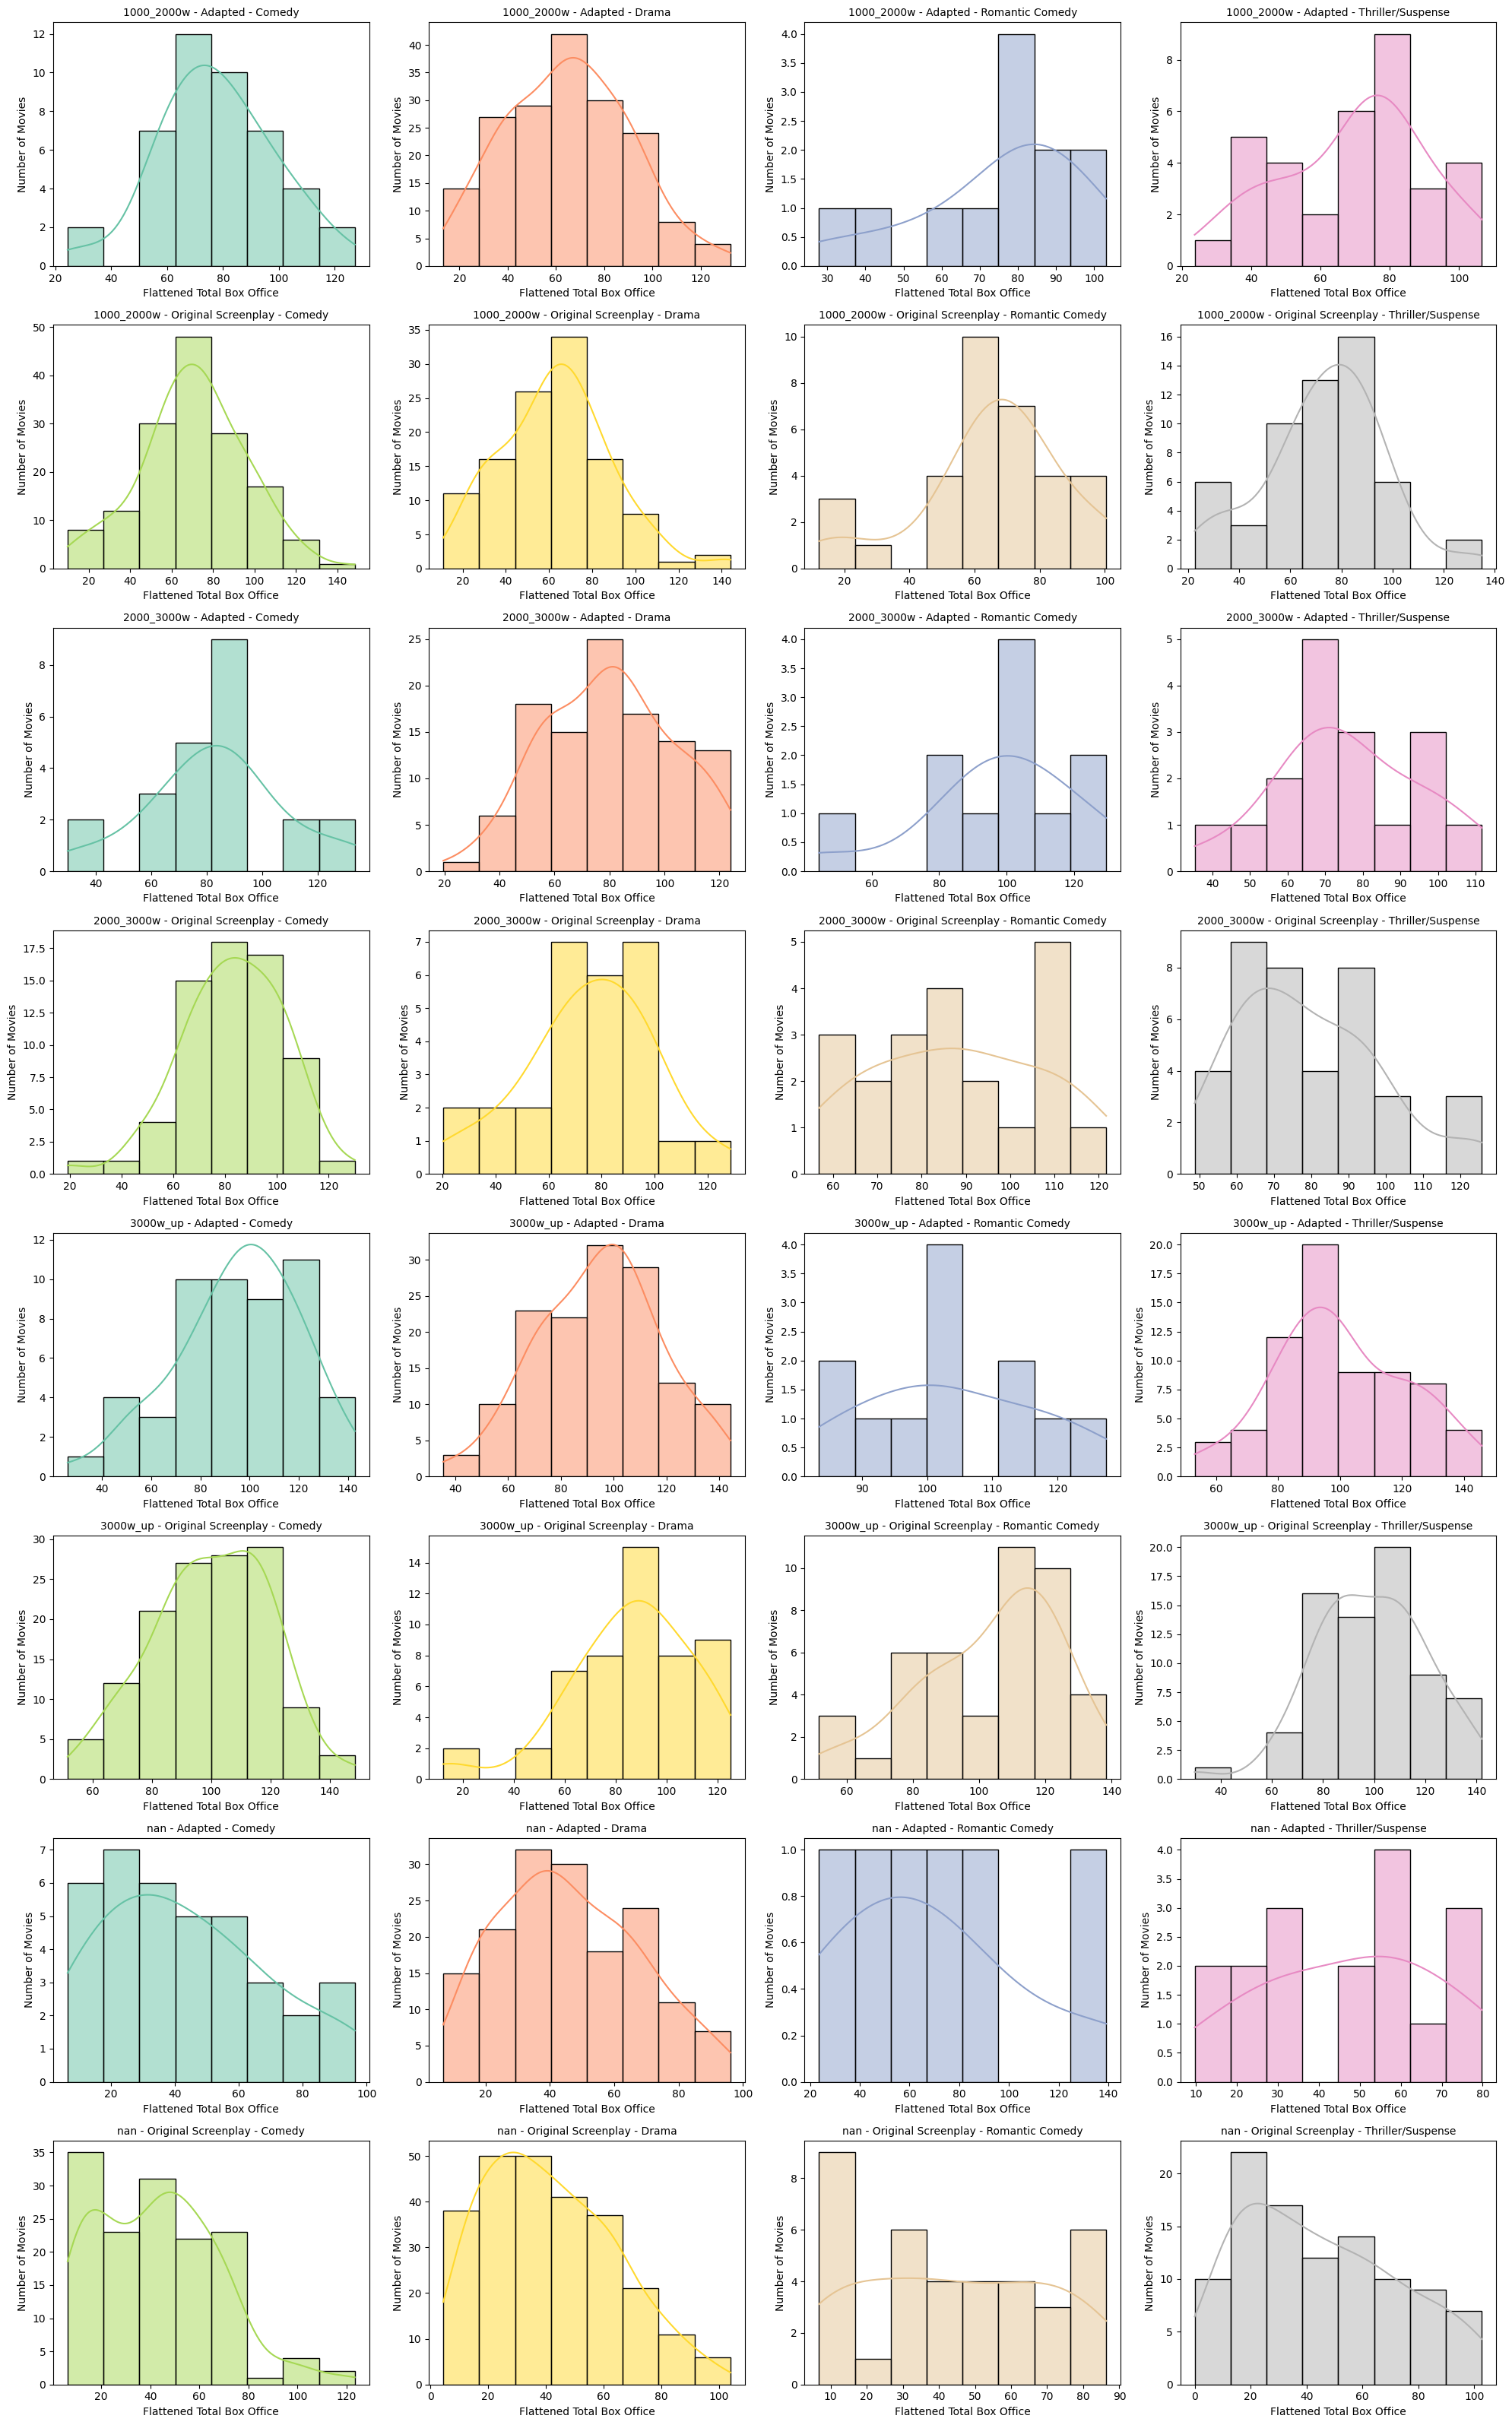

In [33]:
import math

# 根據 group_labels 的長度決定圖的排列方式
n_groups = len(group_labels)
ncols = 4  # 每行顯示 3 圖
nrows = math.ceil(n_groups / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
axes = axes.flatten()

# 避免超出 palette 長度
palette = sns.color_palette("Set2", n_colors=n_groups)

for i, label in enumerate(group_labels):
    data = filtered_df[filtered_df['group_label'] == label]
    sns.histplot(
        data=data,
        x='flattened_total_box_office',
        bins=8,
        kde=True,
        ax=axes[i],
        color=palette[i]
    )
    axes[i].set_title(label, fontsize=10)
    axes[i].set_xlabel("Flattened Total Box Office")
    axes[i].set_ylabel("Number of Movies")

# 對於多餘的子圖格子進行清空處理
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.p

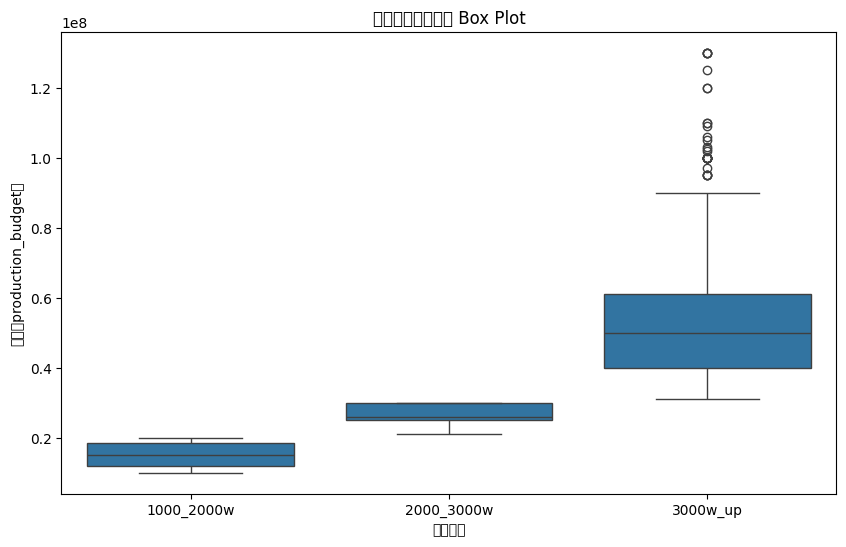

C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.p

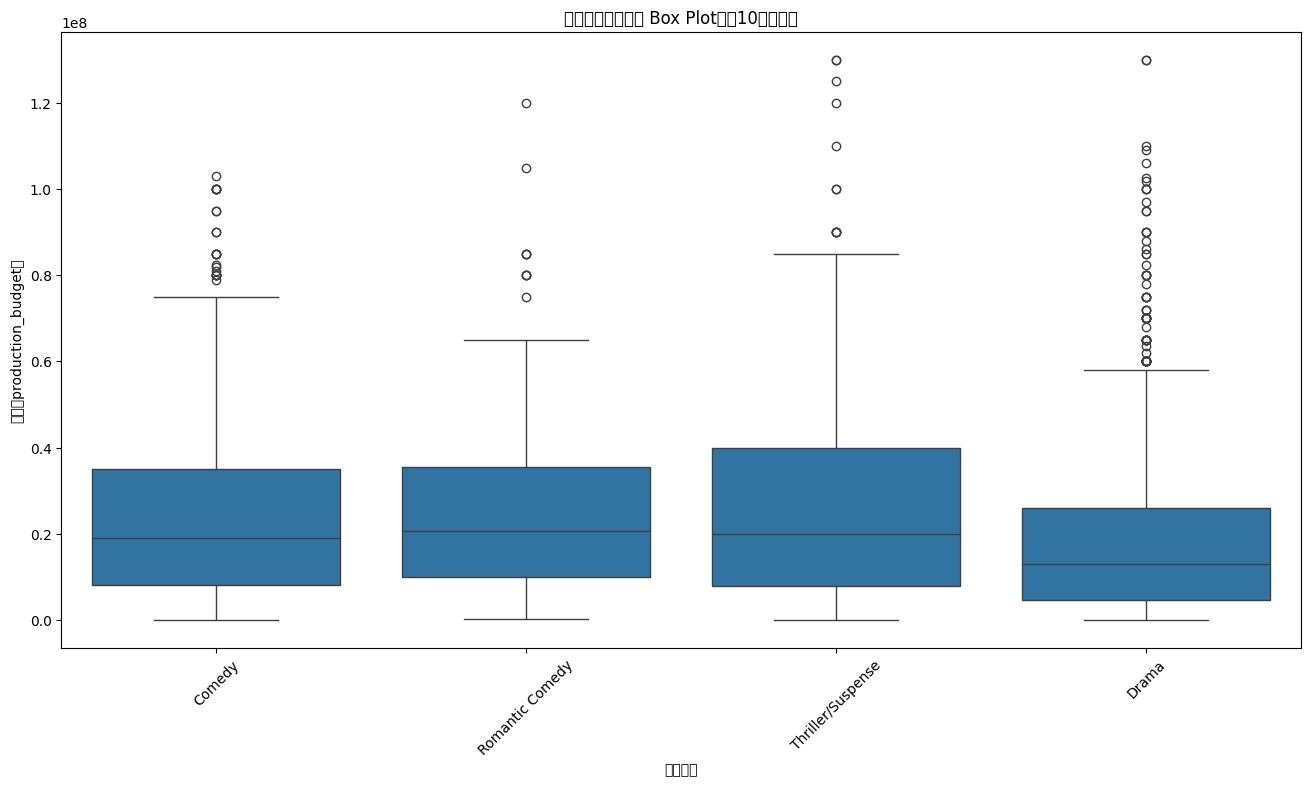

C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.p

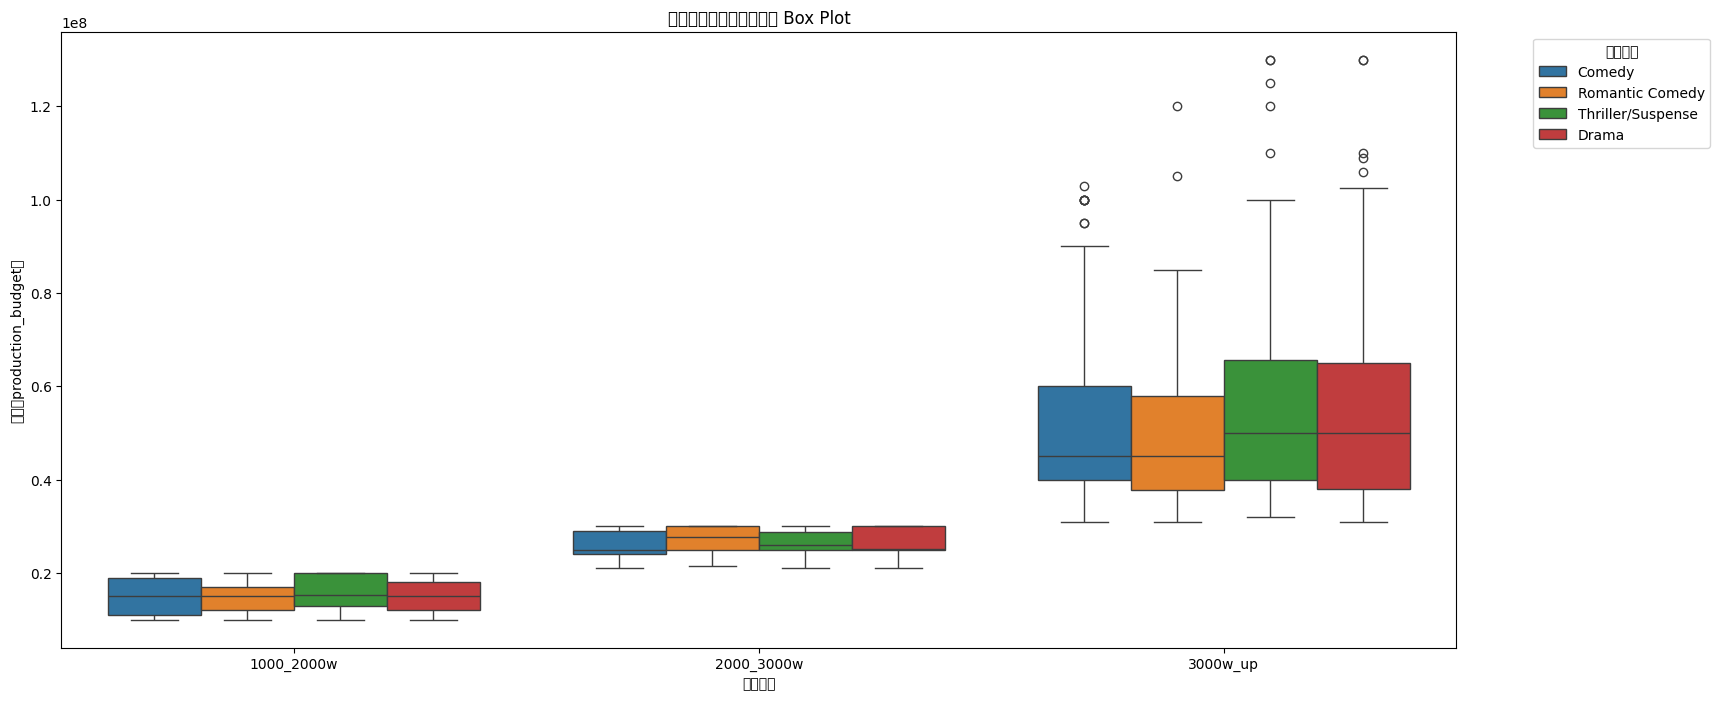

C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21312 (\N{CJK UNIFIED IDEOGRAPH-5340}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chenj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py

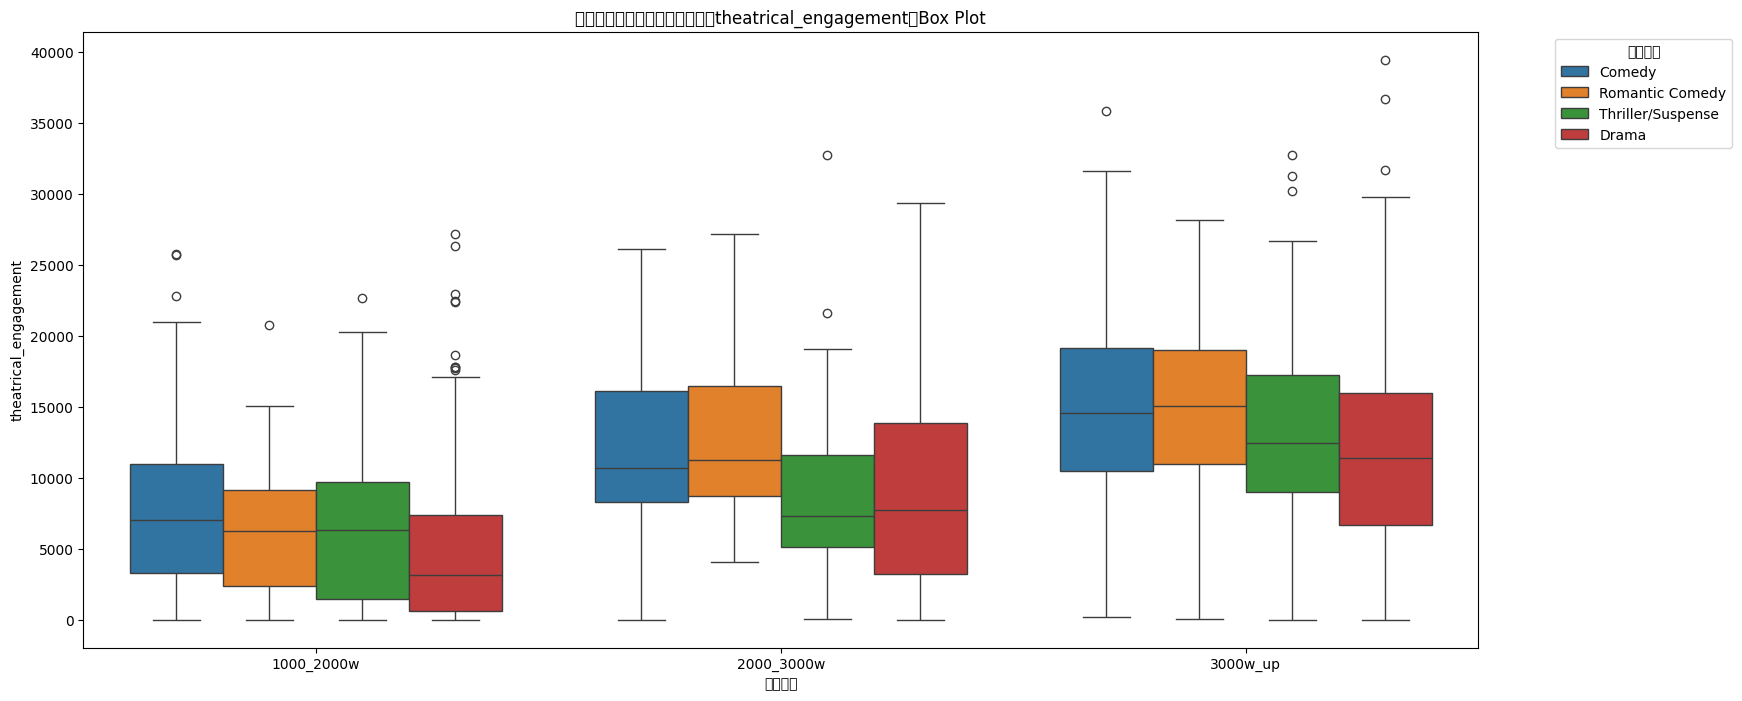

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='budget_group', y='production_budget', data=filtered_df)
plt.title('各預算區間的預算 Box Plot')
plt.xlabel('預算區間')
plt.ylabel('預算（production_budget）')
plt.show()

plt.figure(figsize=(16, 8))
top_genres = filtered_df['genre'].value_counts().index[:10]
sns.boxplot(x='genre', y='production_budget', data=filtered_df[filtered_df['genre'].isin(top_genres)])
plt.title('各類型電影的預算 Box Plot（前10大類型）')
plt.xlabel('電影類型')
plt.ylabel('預算（production_budget）')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(18, 8))
sns.boxplot(x='budget_group', y='production_budget', hue='genre', data=filtered_df[filtered_df['genre'].isin(top_genres)])
plt.title('各預算區間與類型的預算 Box Plot')
plt.xlabel('預算區間')
plt.ylabel('預算（production_budget）')
plt.legend(title='電影類型', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(18, 8))
sns.boxplot(x='budget_group', y='theatrical_engagements', hue='genre', data=filtered_df[filtered_df['genre'].isin(top_genres)])
plt.title('各預算區間與類型的上映規模（theatrical_engagement）Box Plot')
plt.xlabel('預算區間')
plt.ylabel('theatrical_engagement')
plt.legend(title='電影類型', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [35]:
for label in group_labels:
    x = filtered_df['flattened_total_box_office'][filtered_df['group_label'] == label]
    try:
        c_stat, c_p = chi_square_normality_test(x, 4)
        chi_msg = f"χ² = {c_stat:.4f}, p = {c_p:.4f} → {'常態' if c_p > 0.05 else '不常態'}"
    except ValueError as e:
        chi_msg = f"Chi-square 檢定失敗：{e}"

    print(f"\n預算組別：{label}")
    print(f"Chi-square    : {chi_msg}")


預算組別：1000_2000w - Adapted - Comedy
Chi-square    : χ² = 1.4321, p = 0.6980 → 常態

預算組別：1000_2000w - Adapted - Drama
Chi-square    : χ² = 3.7909, p = 0.2849 → 常態

預算組別：1000_2000w - Adapted - Romantic Comedy
Chi-square    : χ² = 2.7319, p = 0.4348 → 常態

預算組別：1000_2000w - Adapted - Thriller/Suspense
Chi-square    : χ² = 4.1279, p = 0.2480 → 常態

預算組別：1000_2000w - Original Screenplay - Comedy
Chi-square    : χ² = 0.8898, p = 0.8279 → 常態

預算組別：1000_2000w - Original Screenplay - Drama
Chi-square    : χ² = 1.7600, p = 0.6237 → 常態

預算組別：1000_2000w - Original Screenplay - Romantic Comedy
Chi-square    : χ² = 4.8442, p = 0.1836 → 常態

預算組別：1000_2000w - Original Screenplay - Thriller/Suspense
Chi-square    : χ² = 1.5343, p = 0.6744 → 常態

預算組別：2000_3000w - Adapted - Comedy
Chi-square    : χ² = 0.3300, p = 0.9543 → 常態

預算組別：2000_3000w - Adapted - Drama
Chi-square    : χ² = 1.9858, p = 0.5754 → 常態

預算組別：2000_3000w - Adapted - Romantic Comedy
Chi-square    : χ² = 0.4023, p = 0.9398 → 常態

預算組別：2000_3000

In [37]:
from scipy.stats import bartlett

# 預算分組標籤
budget_groups = filtered_df['budget_group'].unique()

# 儲存結果
for budget in budget_groups:
    subset = filtered_df[filtered_df['budget_group'] == budget]
    groups = subset['group_label'].unique()
    group_data = [
        subset[subset['group_label'] == g]['flattened_total_box_office'].values
        for g in groups
    ]

    try:
        stat, p = bartlett(*group_data)
        print(f"\n💰 預算區間：{budget}")
        print(f"Bartlett’s test: stat = {stat:.4f}, p = {p:.4f} → {'✔️ 變異數相同' if p > 0.05 else '❌ 變異數不相同'}")
    except Exception as e:
        print(f"\n預算區間：{budget} → ❌ 無法進行 Bartlett’s test：{e}")



💰 預算區間：3000w_up
Bartlett’s test: stat = 10.2953, p = 0.1724 → ✔️ 變異數相同

預算區間：nan → ❌ 無法進行 Bartlett’s test：Must enter at least two input sample vectors.

💰 預算區間：2000_3000w
Bartlett’s test: stat = 5.9251, p = 0.5485 → ✔️ 變異數相同

💰 預算區間：1000_2000w
Bartlett’s test: stat = 5.9406, p = 0.5467 → ✔️ 變異數相同


In [39]:
bin_edges = [0, 10_000_000, 20_000_000, 30_000_000, float('inf')]
bin_labels = ['0_1000w', '1000_2000w', '2000_3000w', '3000w以上']

filtered_df['budget_group'] = pd.cut(
    filtered_df['production_budget'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

import statsmodels.formula.api as smf
import statsmodels.api as sm

for group in bin_labels:
    sub_df = filtered_df[filtered_df['budget_group'] == group]
    print(f"=== 預算區間：{group} ===")
    if len(sub_df) < 2:
        print("資料太少，無法分析\n")
        continue
    model = smf.ols(
        'flattened_total_box_office ~ C(genre) + C(source_category) + C(genre):C(source_category)',
        data=sub_df
    ).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    display(anova_table)

=== 預算區間：0_1000w ===


,sum_sq,df,F,PR(>F)
C(genre),2713.423055,3.0,1.527272,0.205952
C(source_category),4101.782188,1.0,6.926164,0.008651
C(genre):C(source_category),1173.838097,3.0,0.660704,0.576369
Residual,496276.632883,838.0,NaN,NaN


=== 預算區間：1000_2000w ===


,sum_sq,df,F,PR(>F)
C(genre),8946.942213,3.0,5.154452,0.001614
C(source_category),332.232337,1.0,0.574210,0.448935
C(genre):C(source_category),1619.038163,3.0,0.932749,0.424586
Residual,299709.573081,518.0,NaN,NaN


=== 預算區間：2000_3000w ===


,sum_sq,df,F,PR(>F)
C(genre),5104.901126,3.0,3.512488,0.015619
C(source_category),261.046268,1.0,0.538848,0.463473
C(genre):C(source_category),933.656643,3.0,0.642414,0.588260
Residual,148242.486960,306.0,NaN,NaN


=== 預算區間：3000w以上 ===


,sum_sq,df,F,PR(>F)
C(genre),8033.522242,3.0,5.541847,0.000938
C(source_category),373.203362,1.0,0.772352,0.379863
C(genre):C(source_category),3387.133771,3.0,2.336581,0.072767
Residual,273976.498203,567.0,NaN,NaN


In [ ]:
# 自動取得所有 group_label（無需手動列出）
group_labels = sorted(filtered_df['group_label'].unique())

# 顯示每個 group_label 的樣本數與欄位數
group_shapes = {
    label: filtered_df[filtered_df['group_label'] == label].shape
    for label in group_labels
}
print("📦 各 group_label 的樣本數與欄位數：")
for label, shape in group_shapes.items():
    print(f"{label:<40} : {shape}")

# 計算每個 group_label 的票房標準差（flattened）
variances = {
    label: filtered_df[filtered_df['group_label'] == label]["flattened_total_box_office"].std(ddof=1)
    for label in group_labels
}
print("\n📊 各 group_label 的 flattened_total_box_office 標準差：")
for label, var in variances.items():
    print(f"{label:<40} : {var:.4f}")


📦 各 group_label 的樣本數與欄位數：
Adapted - Comedy                         : (111, 31)
Adapted - Drama                          : (404, 31)
Adapted - Romantic Comedy                : (34, 31)
Adapted - Thriller/Suspense              : (119, 31)
Original Screenplay - Comedy             : (319, 31)
Original Screenplay - Drama              : (176, 31)
Original Screenplay - Romantic Comedy    : (93, 31)
Original Screenplay - Thriller/Suspense  : (159, 31)

📊 各 group_label 的 flattened_total_box_office 標準差：
Adapted - Comedy                         : 24.6460
Adapted - Drama                          : 26.9061
Adapted - Romantic Comedy                : 20.4257
Adapted - Thriller/Suspense              : 25.5245
Original Screenplay - Comedy             : 24.0446
Original Screenplay - Drama              : 26.1983
Original Screenplay - Romantic Comedy    : 25.8897
Original Screenplay - Thriller/Suspense  : 24.6448


In [ ]:
# 自動取得所有 group_label（無需手動列出）
group_labels = sorted(filtered_df['group_label'].unique())

# 顯示每個 group_label 的樣本數與欄位數
group_shapes = {
    label: filtered_df[filtered_df['group_label'] == label].shape
    for label in group_labels
}
print("📦 各 group_label 的樣本數與欄位數：")
for label, shape in group_shapes.items():
    print(f"{label:<40} : {shape}")

# 計算每個 group_label 的票房標準差（flattened）
variances = {
    label: filtered_df[filtered_df['group_label'] == label]["flattened_total_box_office"].std(ddof=1)
    for label in group_labels
}
print("\n📊 各 group_label 的 flattened_total_box_office 標準差：")
for label, var in variances.items():
    print(f"{label:<40} : {var:.4f}")


📦 各 group_label 的樣本數與欄位數：
Adapted - Comedy                         : (111, 31)
Adapted - Drama                          : (404, 31)
Adapted - Romantic Comedy                : (34, 31)
Adapted - Thriller/Suspense              : (119, 31)
Original Screenplay - Comedy             : (319, 31)
Original Screenplay - Drama              : (176, 31)
Original Screenplay - Romantic Comedy    : (93, 31)
Original Screenplay - Thriller/Suspense  : (159, 31)

📊 各 group_label 的 flattened_total_box_office 標準差：
Adapted - Comedy                         : 24.6460
Adapted - Drama                          : 26.9061
Adapted - Romantic Comedy                : 20.4257
Adapted - Thriller/Suspense              : 25.5245
Original Screenplay - Comedy             : 24.0446
Original Screenplay - Drama              : 26.1983
Original Screenplay - Romantic Comedy    : 25.8897
Original Screenplay - Thriller/Suspense  : 24.6448


In [45]:
# 預算分組
bin_edges = [0, 10_000_000, 20_000_000, 30_000_000, float('inf')]
bin_labels = ['0_1000w', '1000_2000w', '2000_3000w', '3000w以上']
filtered_df['budget_group'] = pd.cut(
    filtered_df['production_budget'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

from statsmodels.stats.multicomp import pairwise_tukeyhsd

for group in bin_labels:
    sub_df = filtered_df[filtered_df['budget_group'] == group]
    print(f"=== 預算區間：{group} ===")
    if len(sub_df) < 2:
        print("資料太少，無法分析\n")
        continue
    # 1. genre
    print("\nTukey HSD: genre")
    tukey1 = pairwise_tukeyhsd(sub_df['flattened_total_box_office'], sub_df['genre'])
    print(tukey1.summary())
    # 2. source_category
    print("\nTukey HSD: source_category")
    tukey2 = pairwise_tukeyhsd(sub_df['flattened_total_box_office'], sub_df['source_category'])
    print(tukey2.summary())
    # 3. genre:source_category
    print("\nTukey HSD: genre:source_category")
    sub_df['genre_source'] = sub_df['genre'].astype(str) + ':' + sub_df['source_category'].astype(str)
    tukey3 = pairwise_tukeyhsd(sub_df['flattened_total_box_office'], sub_df['genre_source'])
    print(tukey3.summary())
    print("\n==============================\n")

=== 預算區間：0_1000w ===

Tukey HSD: genre
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------
         Comedy             Drama  -1.4229 0.8946  -6.6078   3.762  False
         Comedy   Romantic Comedy    2.672 0.9001  -7.2649 12.6089  False
         Comedy Thriller/Suspense   1.5282 0.9441  -5.5086  8.5649  False
          Drama   Romantic Comedy   4.0949 0.6799  -5.3522  13.542  False
          Drama Thriller/Suspense   2.9511 0.6265  -3.3751  9.2772  False
Romantic Comedy Thriller/Suspense  -1.1439 0.9925 -11.7212  9.4334  False
-------------------------------------------------------------------------

Tukey HSD: source_category
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
 group1        group2       meandiff p-adj   lower   upper  reject
-----------------------------------------------------------

C:\Users\chenj\AppData\Local\Temp\ipykernel_21164\930053928.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['genre_source'] = sub_df['genre'].astype(str) + ':' + sub_df['source_category'].astype(str)


                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                               
               group1                               group2                meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------------------------------------
                     Comedy:Adapted            Comedy:Original Screenplay   -4.308 0.9652 -16.6895  8.0734  False
                     Comedy:Adapted                         Drama:Adapted  -1.8694 0.9998 -14.1734 10.4347  False
                     Comedy:Adapted             Drama:Original Screenplay  -6.8419 0.6565 -18.7451  5.0613  False
                     Comedy:Adapted               Romantic Comedy:Adapted  14.4234  0.829 -15.6206 44.4674  False
                     Comedy:Adapted   Romantic Comedy:Original Screenplay  -3.2703 0.9985 -19.1353 12.5947  False
                     Comedy:Adapted             Thriller/Suspense:Adapted  -0.6094    1.

C:\Users\chenj\AppData\Local\Temp\ipykernel_21164\930053928.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['genre_source'] = sub_df['genre'].astype(str) + ':' + sub_df['source_category'].astype(str)


                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                               
               group1                               group2                meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------------------------------------
                     Comedy:Adapted            Comedy:Original Screenplay  -3.2309 0.9968 -17.1554 10.6936  False
                     Comedy:Adapted                         Drama:Adapted -11.3503 0.1782 -24.9107  2.2101  False
                     Comedy:Adapted             Drama:Original Screenplay -12.8605 0.1132 -27.1471   1.426  False
                     Comedy:Adapted               Romantic Comedy:Adapted   1.3323    1.0 -23.8874  26.552  False
                     Comedy:Adapted   Romantic Comedy:Original Screenplay -10.9688 0.6137 -29.4146   7.477  False
                     Comedy:Adapted             Thriller/Suspense:Adapted  -8.8639 0.791

C:\Users\chenj\AppData\Local\Temp\ipykernel_21164\930053928.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['genre_source'] = sub_df['genre'].astype(str) + ':' + sub_df['source_category'].astype(str)


                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                               
               group1                               group2                meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------------------------------------
                     Comedy:Adapted            Comedy:Original Screenplay  -0.3315    1.0 -16.5972 15.9343  False
                     Comedy:Adapted                         Drama:Adapted  -3.6085 0.9965 -19.0229 11.8058  False
                     Comedy:Adapted             Drama:Original Screenplay  -7.8457 0.9104 -26.7498 11.0585  False
                     Comedy:Adapted               Romantic Comedy:Adapted  14.1779 0.6495 -10.4481 38.8039  False
                     Comedy:Adapted   Romantic Comedy:Original Screenplay   4.8402 0.9961 -15.4352 25.1155  False
                     Comedy:Adapted             Thriller/Suspense:Adapted  -7.6184 0.960

C:\Users\chenj\AppData\Local\Temp\ipykernel_21164\930053928.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['genre_source'] = sub_df['genre'].astype(str) + ':' + sub_df['source_category'].astype(str)


                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                               
               group1                               group2                meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------------------------------------
                     Comedy:Adapted            Comedy:Original Screenplay   4.6465 0.9011  -6.2797 15.5726  False
                     Comedy:Adapted                         Drama:Adapted    -0.67    1.0 -11.5098 10.1697  False
                     Comedy:Adapted             Drama:Original Screenplay  -9.4151 0.3696 -22.5945  3.7643  False
                     Comedy:Adapted               Romantic Comedy:Adapted   8.4804 0.9305 -12.9368 29.8975  False
                     Comedy:Adapted   Romantic Comedy:Original Screenplay   8.0491 0.6288  -5.6494 21.7476  False
                     Comedy:Adapted             Thriller/Suspense:Adapted   4.9022 0.927

In [ ]:
# 自動取得所有 group_label（無需手動列出）
group_labels = sorted(filtered_df['group_label'].unique())

# 顯示每個 group_label 的樣本數與欄位數
group_shapes = {
    label: filtered_df[filtered_df['group_label'] == label].shape
    for label in group_labels
}
print("📦 各 group_label 的樣本數與欄位數：")
for label, shape in group_shapes.items():
    print(f"{label:<40} : {shape}")

# 計算每個 group_label 的票房標準差（flattened）
variances = {
    label: filtered_df[filtered_df['group_label'] == label]["flattened_total_box_office"].std(ddof=1)
    for label in group_labels
}
print("\n📊 各 group_label 的 flattened_total_box_office 標準差：")
for label, var in variances.items():
    print(f"{label:<40} : {var:.4f}")


📦 各 group_label 的樣本數與欄位數：
Adapted - Comedy                         : (111, 31)
Adapted - Drama                          : (404, 31)
Adapted - Romantic Comedy                : (34, 31)
Adapted - Thriller/Suspense              : (119, 31)
Original Screenplay - Comedy             : (319, 31)
Original Screenplay - Drama              : (176, 31)
Original Screenplay - Romantic Comedy    : (93, 31)
Original Screenplay - Thriller/Suspense  : (159, 31)

📊 各 group_label 的 flattened_total_box_office 標準差：
Adapted - Comedy                         : 24.6460
Adapted - Drama                          : 26.9061
Adapted - Romantic Comedy                : 20.4257
Adapted - Thriller/Suspense              : 25.5245
Original Screenplay - Comedy             : 24.0446
Original Screenplay - Drama              : 26.1983
Original Screenplay - Romantic Comedy    : 25.8897
Original Screenplay - Thriller/Suspense  : 24.6448


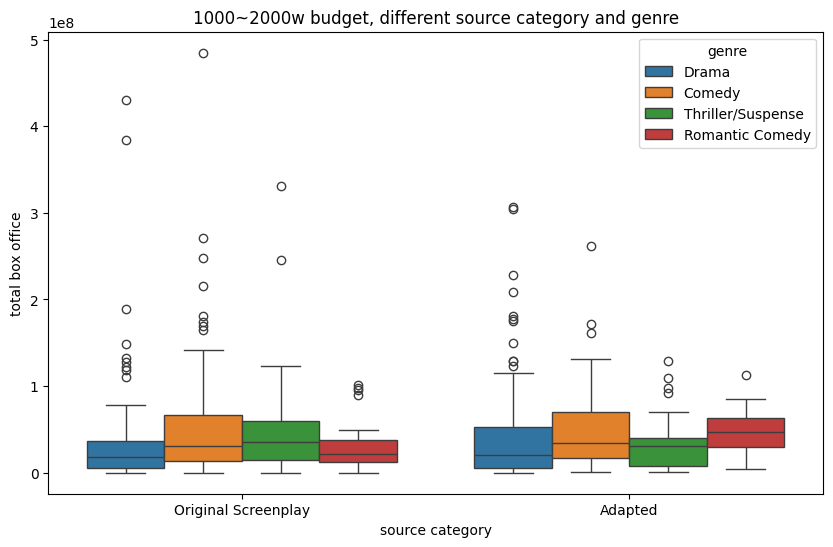

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# 只取預算1000~2000萬的資料
df_1000_2000w = filtered_df[filtered_df['budget_group'] == '1000_2000w'].copy()

# 只取出現次數最多的4個genre（避免太雜亂）
top4_genres = df_1000_2000w['genre'].value_counts().index[:4]
df_1000_2000w = df_1000_2000w[df_1000_2000w['genre'].isin(top4_genres)]

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='source_category',
    y='total_box_office',  # 或 'flattened_total_box_office'
    hue='genre',
    data=df_1000_2000w
)
plt.title('1000~2000w budget, different source category and genre')
plt.xlabel('source category')
plt.ylabel('total box office')
plt.legend(title='genre')
plt.show()